# Eng. Abdallah Dwikat, Elevvopath Intern, 17th of September 2025.
## Student score prediction

## Imports

In [2]:
!pip install kagglehub


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import kagglehub
import pandas as pd

# Core
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Plotting (as required: Matplotlib)
import matplotlib.pyplot as plt

# Scikit‑learn (we’ll use these soon)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reproducibility + display
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", None)

## Load Data

In [4]:
# Download latest version
path = kagglehub.dataset_download("lainguyn123/student-performance-factors")

print("Path to dataset files:", path)

100%|██████████████████████████████████████████████████████████████████████████████| 93.9k/93.9k [00:00<00:00, 419kB/s]

Extracting files...
Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\lainguyn123\student-performance-factors\versions\9


In [7]:
import os

# List files in the downloaded directory
files = os.listdir(path)
print("Files in dataset:", files)

# Load the CSV file (adjust filename if needed)
csv_file = [f for f in files if f.endswith('.csv')][0]  # grabs the first CSV file
df = pd.read_csv(os.path.join(path, csv_file))

# Display the DataFrame
print(df.head())

Files in dataset: ['StudentPerformanceFactors.csv']
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessio

In [9]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


## Data Preprocessing

In [13]:
print("Shape:", df.shape)          # rows, columns

# column info: datatypes + non-null counts
print("\nInfo:")
df.info()

# missing values count
print("\nMissing values:\n", df.isnull().sum())

Shape: (6607, 20)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence         

In [14]:
(df.isnull().sum() / len(df)) * 100

Hours_Studied                 0.000000
Attendance                    0.000000
Parental_Involvement          0.000000
Access_to_Resources           0.000000
Extracurricular_Activities    0.000000
Sleep_Hours                   0.000000
Previous_Scores               0.000000
Motivation_Level              0.000000
Internet_Access               0.000000
Tutoring_Sessions             0.000000
Family_Income                 0.000000
Teacher_Quality               1.180566
School_Type                   0.000000
Peer_Influence                0.000000
Physical_Activity             0.000000
Learning_Disabilities         0.000000
Parental_Education_Level      1.362192
Distance_from_Home            1.014076
Gender                        0.000000
Exam_Score                    0.000000
dtype: float64

### The above step is very important to know if you have to deal with nan or null values or not , and to understand the types of data and columns

### since null Values are a few ~1.0% the solution is to impute with most frequent category

In [16]:
categorical_imputer = SimpleImputer(strategy="most_frequent")

### heatmap (see relationships across all numeric features), print which numeric columns are most/least correlated with Exam_Score.

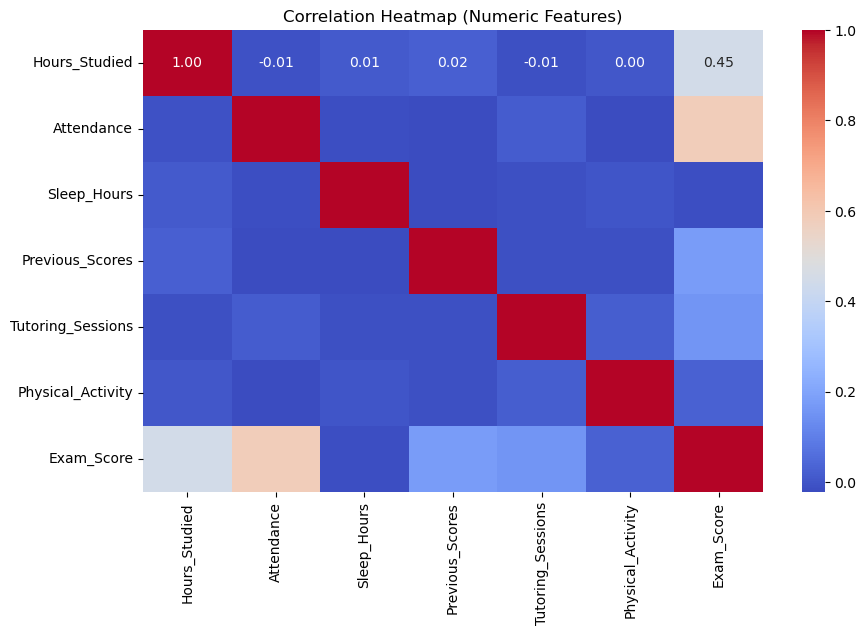

Exam_Score           1.000000
Attendance           0.581072
Hours_Studied        0.445455
Previous_Scores      0.175079
Tutoring_Sessions    0.156525
Physical_Activity    0.027824
Sleep_Hours         -0.017022
Name: Exam_Score, dtype: float64


In [17]:
import seaborn as sns

# select only numeric columns
num_cols = df.select_dtypes(include=['int64','float64']).columns

# correlation matrix
corr = df[num_cols].corr()

# heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# look at correlations with Exam_Score only
print(corr["Exam_Score"].sort_values(ascending=False))

### (Exam_Score vs Teacher_Quality, Parental_Education_Level, Distance_from_Home)

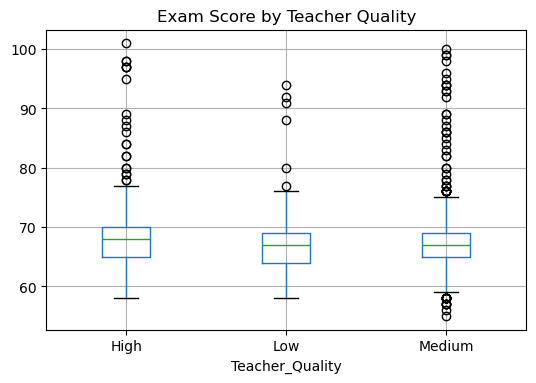

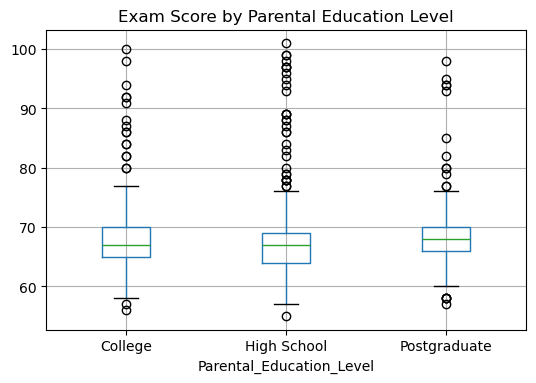

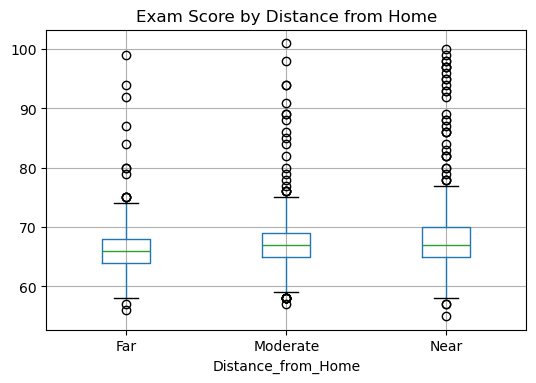

In [18]:
# teacher quality vs exam score
df.boxplot(column="Exam_Score", by="Teacher_Quality", figsize=(6,4))
plt.title("Exam Score by Teacher Quality")
plt.suptitle("")
plt.show()

# parental education vs exam score
df.boxplot(column="Exam_Score", by="Parental_Education_Level", figsize=(6,4))
plt.title("Exam Score by Parental Education Level")
plt.suptitle("")
plt.show()

# distance from home vs exam score
df.boxplot(column="Exam_Score", by="Distance_from_Home", figsize=(6,4))
plt.title("Exam Score by Distance from Home")
plt.suptitle("")
plt.show()

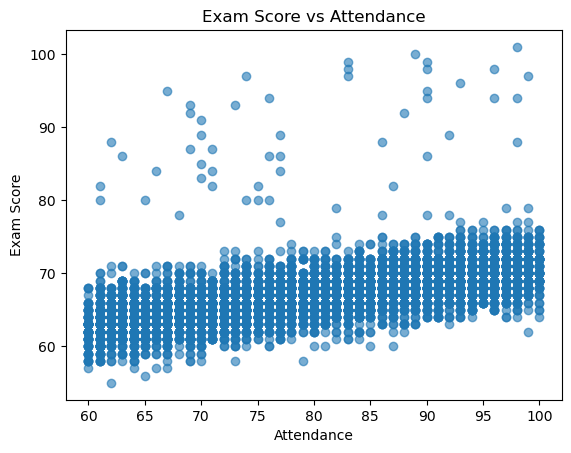

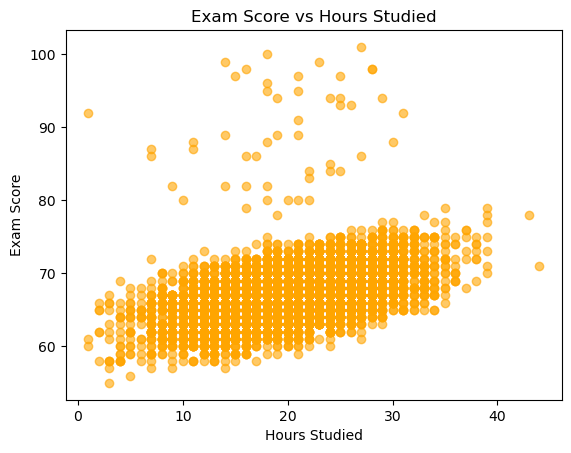

In [19]:
# Exam Score vs Attendance
plt.scatter(df["Attendance"], df["Exam_Score"], alpha=0.6)
plt.xlabel("Attendance")
plt.ylabel("Exam Score")
plt.title("Exam Score vs Attendance")
plt.show()

# Exam Score vs Hours Studied
plt.scatter(df["Hours_Studied"], df["Exam_Score"], alpha=0.6, color="orange")
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Exam Score vs Hours Studied")
plt.show()

## Train Test Split

In [20]:
from sklearn.model_selection import train_test_split

# 1. separate features & target
X = df.drop("Exam_Score", axis=1)
y = df["Exam_Score"]

# 2. split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (5285, 19)
Test set shape: (1322, 19)


## Model Building

In [62]:
# ✅ Numeric features
numeric_features = [
    "Hours_Studied", "Attendance", "Sleep_Hours", "Previous_Scores",
    "Tutoring_Sessions", "Physical_Activity"
]

# ✅ Ordinal features and their categories
ordinal_features = [
    "Motivation_Level",              # ['Low', 'Medium', 'High']
    "Distance_from_Home",           # ['Near', 'Moderate', 'Far']
    "Parental_Education_Level",     # ['High School', 'College', 'Postgraduate']
    "Parental_Involvement",         # ['Low', 'Medium', 'High']
    "Access_to_Resources",          # ['Low', 'Medium', 'High']
    "Family_Income",                # ['Low', 'Medium', 'High']
    "Teacher_Quality"               # ['Low', 'Medium', 'High']
]

ordinal_categories = [
    ["Low", "Medium", "High"],                    # Motivation_Level
    ["Near", "Moderate", "Far"],                  # Distance_from_Home
    ["High School", "College", "Postgraduate"],   # Parental_Education_Level
    ["Low", "Medium", "High"],                    # Parental_Involvement
    ["Low", "Medium", "High"],                    # Access_to_Resources
    ["Low", "Medium", "High"],                    # Family_Income
    ["Low", "Medium", "High"]                     # Teacher_Quality
]

# ✅ Nominal features
nominal_features = [
    "Internet_Access", "School_Type", "Learning_Disabilities", "Gender",
    "Extracurricular_Activities", "Peer_Influence"
]

In [63]:
assert len(ordinal_features) == len(ordinal_categories), "Mismatch in ordinal encoder setup"

In [64]:
for col, cats in zip(ordinal_features, ordinal_categories):
    actual = sorted(X_train[col].dropna().unique())
    expected = sorted(cats)
    if actual != expected:
        print(f"⚠️ Mismatch in {col}: actual={actual}, expected={expected}")

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Numeric pipeline
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

# Ordinal pipeline
ordinal_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=ordinal_categories))
])

# Nominal pipeline
nominal_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ord", ordinal_transformer, ordinal_features),
        ("nom", nominal_transformer, nominal_features),
    ],
    remainder="drop"
)

In [66]:
# Fit on training data only
preprocessor.fit(X_train)

# Transform training data
Xt_train = preprocessor.transform(X_train)

# Check shape
print("Transformed train shape:", Xt_train.shape)

Transformed train shape: (5285, 26)


In [67]:
# Get readable feature names
feature_names = preprocessor.get_feature_names_out()
print("First 25 feature names:\n", feature_names[:25])

First 25 feature names:
 ['num__Hours_Studied' 'num__Attendance' 'num__Sleep_Hours'
 'num__Previous_Scores' 'num__Tutoring_Sessions' 'num__Physical_Activity'
 'ord__Motivation_Level' 'ord__Distance_from_Home'
 'ord__Parental_Education_Level' 'ord__Parental_Involvement'
 'ord__Access_to_Resources' 'ord__Family_Income' 'ord__Teacher_Quality'
 'nom__Internet_Access_No' 'nom__Internet_Access_Yes'
 'nom__School_Type_Private' 'nom__School_Type_Public'
 'nom__Learning_Disabilities_No' 'nom__Learning_Disabilities_Yes'
 'nom__Gender_Female' 'nom__Gender_Male'
 'nom__Extracurricular_Activities_No'
 'nom__Extracurricular_Activities_Yes' 'nom__Peer_Influence_Negative'
 'nom__Peer_Influence_Neutral']


In [68]:
# Get readable feature names
feature_names = preprocessor.get_feature_names_out()
print("First 25 feature names:\n", feature_names[:25])

First 25 feature names:
 ['num__Hours_Studied' 'num__Attendance' 'num__Sleep_Hours'
 'num__Previous_Scores' 'num__Tutoring_Sessions' 'num__Physical_Activity'
 'ord__Motivation_Level' 'ord__Distance_from_Home'
 'ord__Parental_Education_Level' 'ord__Parental_Involvement'
 'ord__Access_to_Resources' 'ord__Family_Income' 'ord__Teacher_Quality'
 'nom__Internet_Access_No' 'nom__Internet_Access_Yes'
 'nom__School_Type_Private' 'nom__School_Type_Public'
 'nom__Learning_Disabilities_No' 'nom__Learning_Disabilities_Yes'
 'nom__Gender_Female' 'nom__Gender_Male'
 'nom__Extracurricular_Activities_No'
 'nom__Extracurricular_Activities_Yes' 'nom__Peer_Influence_Negative'
 'nom__Peer_Influence_Neutral']


In [69]:
# Apply the preprocessor to the training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed training data shape:", X_train_processed.shape)
print("Processed testing data shape:", X_test_processed.shape)

Processed training data shape: (5285, 26)
Processed testing data shape: (1322, 26)


## Baseline Model

In [70]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# baseline prediction: always predict the mean of y_train
y_pred_baseline = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)

# evaluate
mae = mean_absolute_error(y_test, y_pred_baseline)
mse = mean_squared_error(y_test, y_pred_baseline) # Removed squared=False
rmse = np.sqrt(mse) # Calculate RMSE manually
r2 = r2_score(y_test, y_pred_baseline)

print("📊 Baseline (Mean Predictor) Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

📊 Baseline (Mean Predictor) Performance:
MAE:  2.82
RMSE: 3.76
R²:   -0.00


## Linear Regression

In [71]:

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1) full pipeline: preprocessing + regression
linreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# 2) fit on train
linreg.fit(X_train, y_train)

# 3) predict on test
y_pred = linreg.predict(X_test)

# 4) evaluate
mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("📊 Linear Regression (Test set)")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")

📊 Linear Regression (Test set)
MAE : 0.45
RMSE: 3.24
R²  : 0.771


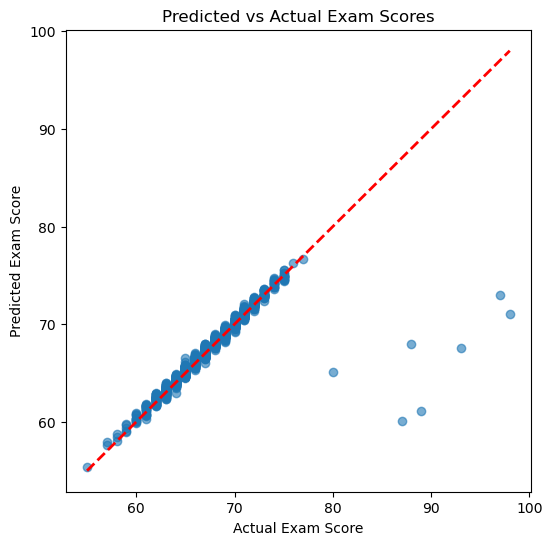

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)  # 45-degree line
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Predicted vs Actual Exam Scores")
plt.show()

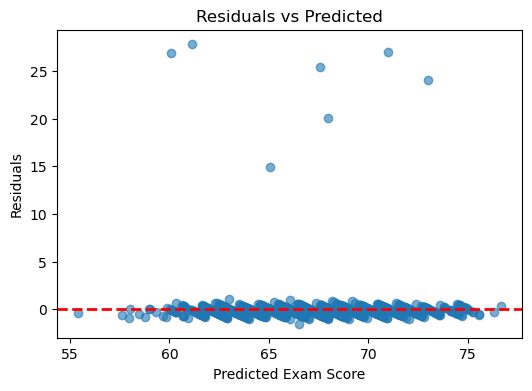

In [73]:
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Exam Score")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

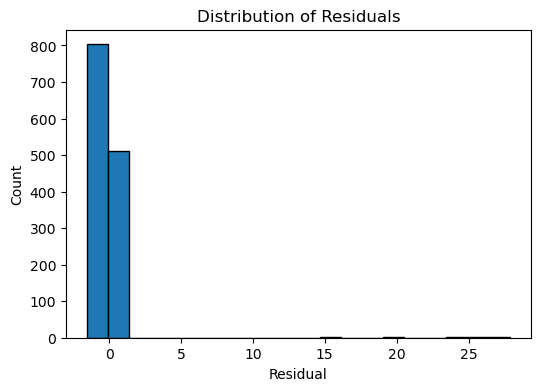

In [74]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, edgecolor="black")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Distribution of Residuals")
plt.show()

## Adding Ploynomial Features

In [75]:
from sklearn.preprocessing import PolynomialFeatures

# polynomial only for study & attendance
poly_features = ["Hours_Studied", "Attendance"]

# pipeline for polynomial numeric features
poly_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))
])

# update ColumnTransformer
preprocessor_poly = ColumnTransformer(
    transformers=[
        ("poly", poly_transformer, poly_features),                # polynomial
        ("num", numeric_transformer, [c for c in numeric_features if c not in poly_features]),  # other numeric
        ("ord", ordinal_transformer, ordinal_features),           # ordinal categories
        ("nom", nominal_transformer, nominal_features)            # nominal categories
    ],
    remainder="drop"
)

In [76]:

linreg_poly = Pipeline(steps=[
    ("preprocessor", preprocessor_poly),
    ("regressor", LinearRegression())
])

linreg_poly.fit(X_train, y_train)
y_pred_poly = linreg_poly.predict(X_test)

# evaluate
mae_poly  = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly   = r2_score(y_test, y_pred_poly)

print("📊 Polynomial Regression (degree=2 on Hours_Studied & Attendance)")
print(f"MAE : {mae_poly:.2f}")
print(f"RMSE: {rmse_poly:.2f}")
print(f"R²  : {r2_poly:.3f}")


📊 Polynomial Regression (degree=2 on Hours_Studied & Attendance)
MAE : 0.45
RMSE: 3.24
R²  : 0.771


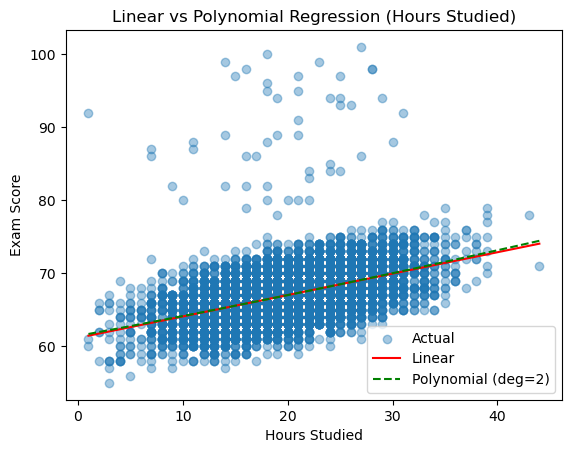

In [77]:
import numpy as np

# make a smooth range of study hours
X_plot = pd.DataFrame({
    "Hours_Studied": np.linspace(X["Hours_Studied"].min(), X["Hours_Studied"].max(), 100),
    "Attendance": np.full(100, X["Attendance"].mean())  # keep attendance fixed at mean
})

# fill in other features with most common values
for col in X.columns:
    if col not in ["Hours_Studied", "Attendance"]:
        if X[col].dtype == "object":
            X_plot[col] = X[col].mode()[0]   # most frequent category
        else:
            X_plot[col] = X[col].median()    # median for numeric

# predict with both models
y_pred_lin  = linreg.predict(X_plot)
y_pred_poly = linreg_poly.predict(X_plot)

# scatter actual data
plt.scatter(X["Hours_Studied"], y, alpha=0.4, label="Actual")

# regression lines
plt.plot(X_plot["Hours_Studied"], y_pred_lin, color="red", label="Linear")
plt.plot(X_plot["Hours_Studied"], y_pred_poly, color="green", linestyle="--", label="Polynomial (deg=2)")

plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Linear vs Polynomial Regression (Hours Studied)")
plt.legend()
plt.show()


## Ridge/Lasso regression

#### Ridge → handles multicollinearity, shrinks coefficients smoothly.
#### 
Lasso → can remove unimportant features completely.#### 

this can stabilize the model and maybe improve generalization.

In [78]:
from sklearn.linear_model import RidgeCV, LassoCV

# RidgeCV: tries multiple alphas (strength of regularization)
ridge = Pipeline(steps=[
    ("preprocessor", preprocessor_poly),   # keep preprocessing (with poly if you want)
    ("regressor", RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5))
])

# LassoCV: tries multiple alphas too
lasso = Pipeline(steps=[
    ("preprocessor", preprocessor_poly),
    ("regressor", LassoCV(alphas=[0.001, 0.01, 0.1, 1.0], cv=5, max_iter=5000, random_state=42))
])

# Fit both
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

# Predict
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

# Evaluate
def evaluate(y_true, y_pred, name):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"📊 {name} Performance")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²  : {r2:.3f}\n")

evaluate(y_test, y_pred_ridge, "Ridge")
evaluate(y_test, y_pred_lasso, "Lasso")

print("Best alpha (Ridge):", ridge.named_steps["regressor"].alpha_)
print("Best alpha (Lasso):", lasso.named_steps["regressor"].alpha_)

📊 Ridge Performance
MAE : 0.45
RMSE: 3.24
R²  : 0.771

📊 Lasso Performance
MAE : 0.45
RMSE: 3.24
R²  : 0.771

Best alpha (Ridge): 10.0
Best alpha (Lasso): 0.001
